In [41]:
# Load various imports 
#latest version with pitch audio too
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display
import IPython.display as ipd

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Flatten, LSTM, TimeDistributed
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
mypath = "/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [file for file in listdir(mypath) if (isfile(join(mypath, file)) and file.endswith('.wav'))] 

In [43]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

In [44]:
# Adding white noise 
def add_noise(data):
    wn = np.random.randn(len(data))
    data_wn = data + 0.002*wn
    return data_wn

# Shifting the sound
def shift_sound(data):
    data_shift = np.roll(data, 1600)
    return data_shift

#streching
def stretch(data, rate=0.98):
    data = librosa.effects.time_stretch(data, rate)
    return data

#adding pitch
def pitch(data,sr):
    return librosa.effects.pitch_shift(data, sr, n_steps=2)
    

In [45]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name,label):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        mfccs_all = []
        allAudio=None
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        if not label == 'COPD':
            noise_audio = add_noise(audio)
            shift_audio = shift_sound(audio)
            stretch_audio = stretch(audio)
            pitch_audio = pitch(audio,sample_rate)
            allAudio = [audio,noise_audio,shift_audio,stretch_audio,pitch_audio]

        else:
            allAudio = [audio]

        
        for single_audio in allAudio:
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            mfccs_all.append(mfccs)
             
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs_all

In [46]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files'


In [47]:
p_diag = pd.read_csv("/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [48]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [49]:
print(labels[len(labels)-3:len(labels)])
print(filepaths[len(labels)-3:len(labels)])

['Bronchiectasis' 'COPD' 'COPD']
['/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/111_1b3_Tc_sc_Meditron.wav', '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/151_2p3_Al_mc_AKGC417L.wav', '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/170_1b4_Pl_mc_AKGC417L.wav']


In [50]:
# print(labels[0:4])
# sometest = []
# sometest.extend([labels[0],labels[0],labels[0],labels[0]])
# print(sometest)
# sometest = np.array(sometest)
# print(sometest)

In [51]:
testPath = "/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/111_1b3_Tc_sc_Meditron.wav"


In [52]:
if not 'abc'== 'abc':
    print("sup")
else:
    print("naah")

naah


In [53]:
features = [] 
newLabels = []

i = 0
# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name,labels[i])
    features.extend(data)
    if labels[i] == 'COPD':
        newLabels.append('COPD')
    else:
        label = labels[i]
        newLabels.extend([label,label,label,label,label])
    i+=1

print('Finished feature extraction from ', len(features), ' files')
print('Finished feature extraction from ', len(newLabels), ' labels')

features = np.array(features)
labels = np.array(newLabels)

Finished feature extraction from  1428  files
Finished feature extraction from  1428  labels


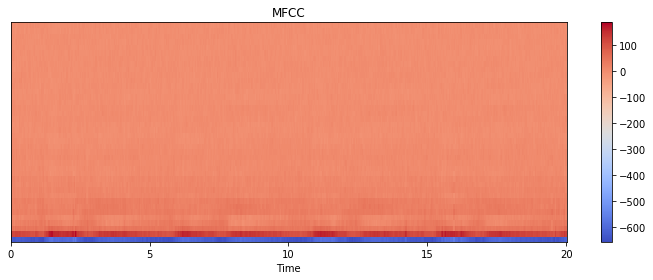

In [54]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [55]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [56]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['80' '65' '793' '175' '185' '115']]


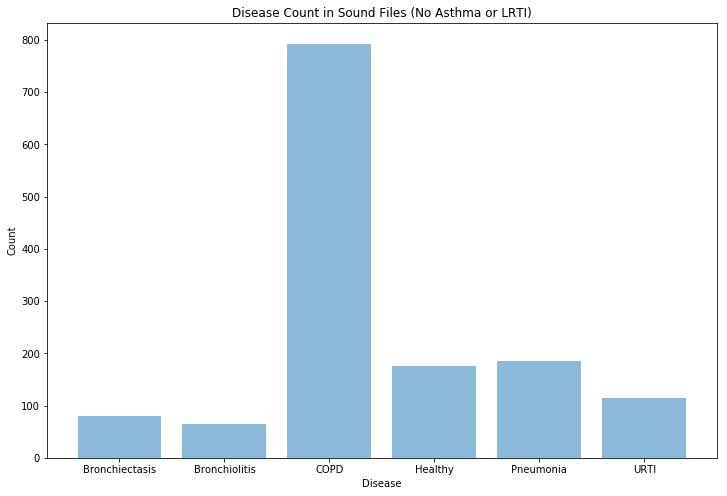

In [57]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [58]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

In [59]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

In [60]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [61]:
print(len(x_test))

283


In [62]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 3
model = Sequential()
model.add(Conv2D(64, kernel_size=5, strides=1, padding='same', input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))


In [63]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [64]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 40, 862, 64)       1664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 862, 64)       256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 431, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 431, 128)      204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 431, 128)      512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 215, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 275200)           

In [65]:
# train model
num_epochs = 10
num_batch_size = 32

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

# method 1 new

# model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
#           validation_split=0.1, shuffle=True, callbacks=callbacks, verbose=1)

# method 2 old
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 1130 samples, validate on 283 samples
Epoch 1/10
1120/1130 [============================>.] - ETA: 0s - loss: 44.5468 - accuracy: 0.4384
Epoch 00001: val_accuracy improved from -inf to 0.14134, saving model to mymodel2.h5
1130/1130 [==============================] - 5s 4ms/sample - loss: 44.3070 - accuracy: 0.4398 - val_loss: 92.9828 - val_accuracy: 0.1413
Epoch 2/10
1120/1130 [============================>.] - ETA: 0s - loss: 3.7601 - accuracy: 0.6286
Epoch 00002: val_accuracy did not improve from 0.14134
1130/1130 [==============================] - 2s 2ms/sample - loss: 3.7313 - accuracy: 0.6292 - val_loss: 22.6720 - val_accuracy: 0.1343
Epoch 3/10
1120/1130 [============================>.] - ETA: 0s - loss: 1.1419 - accuracy: 0.7009
Epoch 00003: val_accuracy improved from 0.14134 to 0.24735, saving model to mymodel2.h5
1130/1130 [==============================] - 5s 4ms/sample - loss: 1.1377 - accuracy: 0.7018 - val_loss: 4.9027 - val_accuracy: 0.2473
Epoch 4/10
1120/1130 [

**Test the model**

Here we will review the accuracy of the model on both the training and test data sets.

In [66]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8415929
Testing Accuracy:  0.84452295


In [67]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=6 # number of classes

In [68]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [69]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

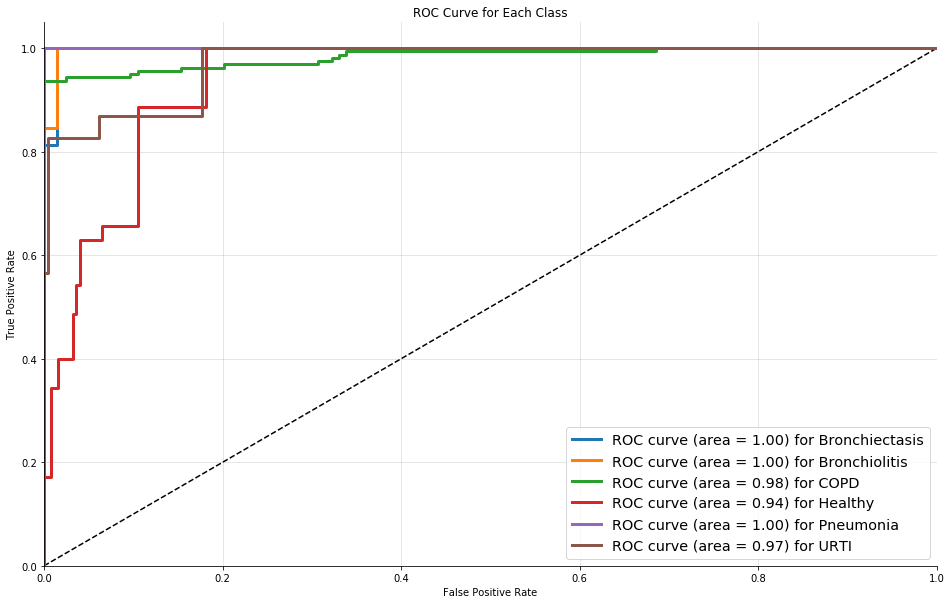

In [70]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [71]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       1.00      0.81      0.90        16
 Bronchiolitis       1.00      0.85      0.92        13
          COPD       0.94      0.94      0.94       159
       Healthy       0.61      0.63      0.62        35
     Pneumonia       1.00      0.62      0.77        37
          URTI       0.50      0.87      0.63        23

      accuracy                           0.84       283
     macro avg       0.84      0.79      0.80       283
  weighted avg       0.88      0.84      0.85       283



In [72]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_testclass, classpreds)

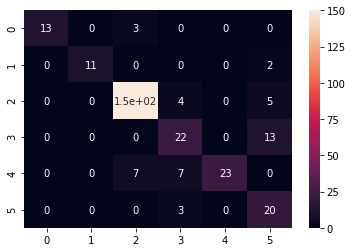

In [73]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

num_rows = 40
num_columns = 862
num_channels = 1
# num_labels = oh_labels.shape[1]

def lstm_model(num_rows, num_columns, num_channels, num_labels):
    lstm_model = Sequential()

    lstm_model.add(LSTM(128, return_sequences=True, input_shape=(num_rows, num_columns,num_channels)))
    lstm_model.add(LSTM(128, return_sequences=True))
    lstm_model.add(TimeDistributed(Dense(256, activation='relu')))
    lstm_model.add(TimeDistributed(Dense(512, activation='relu')))
    lstm_model.add(TimeDistributed(Dense(num_labels, activation='softmax')))
    lstm_model.add(Flatten())
    lstm_model.add(Dense(units=10, activation='softmax'))
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [75]:
# train model
#train_dir = 
num_epochs = 10
num_batch_size = 32

callbacks = [
    ModelCheckpoint(
        filepath='mymodel3.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 1130 samples, validate on 283 samples
Epoch 1/10
1120/1130 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.8741
Epoch 00001: val_accuracy improved from -inf to 0.91519, saving model to mymodel3.h5
1130/1130 [==============================] - 4s 4ms/sample - loss: 0.4796 - accuracy: 0.8752 - val_loss: 0.3073 - val_accuracy: 0.9152
Epoch 2/10
1120/1130 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9527
Epoch 00002: val_accuracy did not improve from 0.91519
1130/1130 [==============================] - 2s 2ms/sample - loss: 0.1474 - accuracy: 0.9531 - val_loss: 0.5289 - val_accuracy: 0.9081
Epoch 3/10
1120/1130 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9518
Epoch 00003: val_accuracy did not improve from 0.91519
1130/1130 [==============================] - 2s 2ms/sample - loss: 0.2020 - accuracy: 0.9522 - val_loss: 0.3982 - val_accuracy: 0.8975
Epoch 4/10
1120/1130 [============================>.] - ETA

In [76]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Testing Accuracy:  0.9893993
